In [1]:
# Assignment
# Part 1: Figure 1 shows a schematic of the robot with a set of coordinate systems following the Denavit-Hartenberg convention. 
# The dimensions given in the schematic are indicative and you might need to revisit them in PART 5 of this assignment, in 
# order to better represent the actual robot that you will work with.


In [2]:
import math
import numpy as np
import sympy as sym
sym.init_printing()

![alt text](Part1_default_config.png "Title")

![alt text](axis_colours.png "Title")

![alt text](references_used.jpg "Title")

In [3]:
# DH - parameters explanation:
'''
th_i    --> Angle between x_{i-1} and x_{i} measured in a plane normal to z_{i-1}
a_i     --> Distance between the axes z_{i-1} and z_{i}, and is measured along the axis x{i}
d_i     --> d is the perpendicular distance from o_{i-1} to the intersection of 
            x_{i} with z_{i-1}, measured along the z_{i-1} axis.
alpha_i --> Angle between the axes z_{i-1} and z_{i}, measured in a plane normal to x_{i}
'''

# Function definitions
def get_norm_vector(x1, x2, x3):
    # Assuming v is your vector
    v = np.array([x1, x2, x3])  # Replace with your vector elements

    # Calculate the magnitude (or norm) of the vector
    magnitude = np.linalg.norm(v)

    # Normalize the vector
    v_normalized = v / magnitude

    return v_normalized

# Rotations
def rot_x_sym(angle):
    # Angle is in radians.
    R = [[1, 0, 0] , [0, sym.cos(angle), -sym.sin(angle)] , [0, sym.sin(angle), sym.cos(angle)]]
    return R

def rot_y_sym(angle):
    # Angle is in radians.
    R = [[sym.cos(angle), 0, sym.sin(angle)] , [0, 1, 0] , [-sym.sin(angle), 0, sym.cos(angle)]]
    return R

def rot_z_sym(angle):
    # Angle is in radians.
    R = [[sym.cos(angle), -sym.sin(angle), 0] , [sym.sin(angle), sym.cos(angle), 0] , [0, 0, 1]]
    return R

def rot_x(angle):
    # Angle is in radians.
    R = [[1, 0, 0] , [0, math.cos(angle), -math.sin(angle)] , [0, math.sin(angle), math.cos(angle)]]
    return R

def rot_y(angle):
    # Angle is in radians.
    R = [[math.cos(angle), 0, math.sin(angle)] , [0, 1, 0] , [-math.sin(angle), 0, math.cos(angle)]]
    return R

def rot_z(angle):
    # Angle is in radians.
    R = [[math.cos(angle), -math.sin(angle), 0] , [math.sin(angle), math.cos(angle), 0] , [0, 0, 1]]
    return R

# Translations
def trans_x(distance):
    d = [distance, 0, 0]
    return d

def trans_y(distance):
    d = [0, distance, 0]
    return d

def trans_z(distance):
    d = [0, 0, distance]
    return d

# Homogeneous Functions
def get_H(R,d):
    H = [[R[0][0], R[0][1], R[0][2], d[0]],
         [R[1][0], R[1][1], R[1][2], d[1]],
         [R[2][0], R[2][1], R[2][2], d[2]],
         [0, 0, 0, 1]]
    return H

def get_R_d_from_H(H):
    R = [[H[0][0:3]],
         [H[1][0:3]],
         [H[2][0:3]]]
    d = [H[0][3], H[1][3], H[2][3]]
    return R, d

def get_A(theta, d, a, alpha):
    R0 = [[1,0,0],[0,1,0],[0,0,1]] # Identity matrix
    A = np.array(get_H(rot_z_sym(theta), [0,0,0])) @ np.array(get_H(R0, trans_z(d))) @\
    np.array(get_H(R0, trans_x(a))) @ np.array(get_H(rot_x_sym(alpha), [0,0,0]))
    return A

def skew(v):
    M = np.array([[0, -v[2], v[1]],
                  [v[2], 0, -v[0]],
                  [-v[1], v[0], 0]])
    return M

def T04_FK(th11, th22, th33, th44):
    TT4_FK = np.array([[1.0*math.cos(th11)*math.cos(th22 + th33 + th44), -1.0*math.sin(th22 + th33 + th44)*math.cos(th11), 1.0*math.sin(th11),
    (0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44))*math.cos(th11)],
    [1.0*math.sin(th11)*math.cos(th22 + th33 + th44), -1.0*math.sin(th11)*math.sin(th22 + th33 + th44), -1.0*math.cos(th11), (0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44))*math.sin(th11)],
    [1.0*math.sin(th22 + th33 + th44), 1.0*math.cos(th22 + th33 + th44), 0, 0.093*math.sin(th22) + 0.093*math.sin(th22 + th33) + 0.05*math.sin(th22 + th33 + th44) + 0.05],
     [0, 0, 0, 1.00000000000000]])
    return TT4_FK

def get_Ji(z_i_1, o_i_1, o_n, joint_type):
    if joint_type == 1:
        Ji = np.concatenate((sym.simplify(np.cross(z_i_1, o_n - o_i_1)), z_i_1), axis = 0)
        #Ji = [sym.simplify(np.cross(z_i_1, o_n - o_i_1)), z_i_1]
    elif joint_type == 0:
        Ji = np.concatenate((z_i_1, [0, 0, 0]), axis = 0)

    return Ji


In [4]:
# Problem 1
#Find, by the use of Figure 1, the direct kinematic transformations, T04 for the robot stylus, and T05 for the robot camera, 
# as function of all joint angles

# Info
joints_type = [1, 1, 1, 1] # 1 for revolute, 0 for prismatic
# Joint variables
th1, th2, th3, th4 = sym.symbols('th1, th2, th3, th4')
# Constants
d1 = 0.050
d2 = 0.093
d3 = 0.093
d4 = 0.050
d5 = 0.035
d5_perp = 0.045

# DH-param
alpha1 = sym.pi/2 # This is OK !!


# DH-param
'''
th_i    --> Angle from x_{i-1} to x_{i} measured in a plane normal to z_{i-1}
d_i     --> d is the perpendicular distance from o_{i-1} to the intersection of 
            x_{i} with z_{i-1}, measured along the z_{i-1} axis.
a_i     --> Distance between the axes z_{i-1} and z_{i}, and is measured along the axis x{i}
alpha_i --> Angle between the axes z_{i-1} and z_{i}, measured in a plane normal to x_{i}
'''

# def get_A(theta, d, a, alpha):
DH_1 = np.array([th1, d1, 0, alpha1])       # OK. Tenemos el mismo
DH_2 = np.array([th2, 0, d2, 0])            # Tenemos el mismo.
#DH_2 = np.array([th2 + sym.pi/2, 0, d2, 0]) # OK
DH_3 = np.array([th3, 0, d3, 0])            # Tenemos el mismo
DH_4 = np.array([th4, 0, d4, 0])            # Tenemos el mismo
DH_5 = np.array([th4, 0, d5, 0]) # Only the first part

A1 = get_A(DH_1[0], DH_1[1], DH_1[2], DH_1[3]) # OK
A2 = get_A(DH_2[0], DH_2[1], DH_2[2], DH_2[3]) # OK
A3 = get_A(DH_3[0], DH_3[1], DH_3[2], DH_3[3]) # OK
A4 = get_A(DH_4[0], DH_4[1], DH_4[2], DH_4[3]) # OK
A5i = get_A(DH_5[0], DH_5[1], DH_5[2], DH_5[3]) # OK
H_trans_y = np.array([[1, 0, 0, 0],
                      [0, 1, 0, d5_perp],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
A5 = A5i @ H_trans_y



# Transformations:
T01 = np.array(sym.simplify(A1))
T02 = np.array(sym.simplify(A1 @ A2))
T03 = np.array(sym.simplify(A1 @ A2 @ A3))
T04 = np.array(sym.simplify(sym.simplify(A1 @ A2 @ A3 @ A4)))
T05 = np.array(sym.simplify(A1 @ A2 @ A3 @ A5))


In [5]:
# Using the geometry from the image:
H01 = np.array([[sym.cos(th1), 0, sym.sin(th1), 0],
               [sym.sin(th1), 0,  -sym.cos(th1), 0],
               [0, 1, 0, d1],
               [0, 0, 0, 1]]) # OK
H12 = np.array([[sym.cos(th2), -sym.sin(th2), 0, d2*sym.cos(th2)],
               [sym.sin(th2), sym.cos(th2), 0, d2*sym.sin(th2)],
               [0, 0, 1, 0],
               [0, 0, 0, 1]]) # OK
H23 = np.array([[sym.cos(th3), -sym.sin(th3), 0, d3*sym.cos(th3)],
               [sym.sin(th3), sym.cos(th3), 0, d3*sym.sin(th3)],
               [0, 0, 1, 0],
               [0, 0, 0, 1]]) # OK
H34 = np.array([[sym.cos(th4), -sym.sin(th4), 0, d4*sym.cos(th4)],
               [sym.sin(th4), sym.cos(th4), 0, d4*sym.sin(th4)],
               [0, 0, 1, 0],
               [0, 0, 0, 1]]) # OK
Hb = np.array([[sym.cos(th4), -sym.sin(th4), 0, 0],
               [sym.sin(th4), sym.cos(th4), 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1]]) # OK. Esto lo tira para arriba nada mas
Hc = np.array([[1, 0, 0, d5],
               [0, 1, 0, d5_perp],
               [0, 0, 1, 0],
               [0, 0, 0, 1]]) # OK.
H35 = Hb @ Hc

In [6]:
# Checking and printing:
# The value of A_i and H_i should be the same
print('A1')
print(A1)
print('A2')
print(A2)
print('A3')
print(A3)
print('A4')
print(A4)
print('A5')
print(A5)
print('A-H --> Should be 0:')
print(A1 - H01)
print(A2 - H12)
print(A3 - H23)
print(A4 - H34)
print(A5 - H35)

# Printing Final results:
print('T01')
print(T01)
print('T02')
print(T02)
print('T03')
print(T03)
print('T04')
print(T04)
print('T05')
print(T05)
print('Checking transformations: T04 and T05')
print(np.array(sym.simplify(H01 @ H12 @ H23 @ H34)) - T04)
print(np.array(sym.simplify(H01 @ H12 @ H23 @ H35)) - T05)

A1
[[1.0*cos(th1) 0 1.0*sin(th1) 0]
 [1.0*sin(th1) 0 -1.0*cos(th1) 0]
 [0.0 1.00000000000000 0 0.05]
 [0.0 0 0 1.0]]
A2
[[1.0*cos(th2) -1.0*sin(th2) 0 0.093*cos(th2)]
 [1.0*sin(th2) 1.0*cos(th2) 0 0.093*sin(th2)]
 [0.0 0 1.00000000000000 0.0]
 [0.0 0 0 1.0]]
A3
[[1.0*cos(th3) -1.0*sin(th3) 0 0.093*cos(th3)]
 [1.0*sin(th3) 1.0*cos(th3) 0 0.093*sin(th3)]
 [0.0 0 1.00000000000000 0.0]
 [0.0 0 0 1.0]]
A4
[[1.0*cos(th4) -1.0*sin(th4) 0 0.05*cos(th4)]
 [1.0*sin(th4) 1.0*cos(th4) 0 0.05*sin(th4)]
 [0.0 0 1.00000000000000 0.0]
 [0.0 0 0 1.0]]
A5
[[1.0*cos(th4) -1.0*sin(th4) 0 -0.045*sin(th4) + 0.035*cos(th4)]
 [1.0*sin(th4) 1.0*cos(th4) 0 0.035*sin(th4) + 0.045*cos(th4)]
 [0 0 1.00000000000000 0]
 [0 0 0 1.00000000000000]]
A-H --> Should be 0:
[[0 0 0 0]
 [0 0 0 0]
 [0.0 0 0 0.0]
 [0.0 0 0 0.0]]
[[0 0 0 0]
 [0 0 0 0]
 [0.0 0 0 0.0]
 [0.0 0 0 0.0]]
[[0 0 0 0]
 [0 0 0 0]
 [0.0 0 0 0.0]
 [0.0 0 0 0.0]]
[[0 0 0 0]
 [0 0 0 0]
 [0.0 0 0 0.0]
 [0.0 0 0 0.0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0

![alt text](Jacobian_calculation.png "Title")

In [7]:
def get_Ji(z_i_1, o_i_1, o_n, joint_type):
    # Joint type 1 --> Revolute joint
    if joint_type == 1:
        Ji = np.concatenate((sym.simplify(np.cross(z_i_1, o_n - o_i_1)), z_i_1), axis = 0)
        #Ji = [sym.simplify(np.cross(z_i_1, o_n - o_i_1)), z_i_1]
    elif joint_type == 0:
        Ji = np.concatenate((z_i_1, [0, 0, 0]), axis = 0)

    return Ji

In [33]:
# Symbolic Jacobian:
# Data:
z0 = np.array([0, 0, 1])
z1 = np.array([T01[0][2], T01[1][2], T01[2][2]])
z2 = np.array([T02[0][2], T02[1][2], T02[2][2]])
z3 = np.array([T03[0][2], T03[1][2], T03[2][2]])
z4 = np.array([T04[0][2], T04[1][2], T04[2][2]])
z5 = np.array([T05[0][2], T05[1][2], T05[2][2]])
o0 = np.array([0, 0, 0])
o1 = np.array([T01[0][3], T01[1][3], T01[2][3]])
o2 = np.array([T02[0][3], T02[1][3], T02[2][3]])
o3 = np.array([T03[0][3], T03[1][3], T03[2][3]])
o4 = np.array([T04[0][3], T04[1][3], T04[2][3]])
o5 = np.array([T05[0][3], T05[1][3], T05[2][3]])
# For J4
J41 = np.concatenate([np.cross(z0, (o4 - o0)), [z0[0], z0[1], z0[2]]])
J42 = np.concatenate([np.cross(z1, (o4 - o1)), [z1[0], z1[1], z1[2]]])
J43 = np.concatenate([np.cross(z2, (o4 - o2)), [z2[0], z2[1], z2[2]]])
J44 = np.concatenate([np.cross(z3, (o4 - o3)), [z3[0], z3[1], z3[2]]])
J4 = np.transpose(np.array([J41, J42, J43, J44]))

# For J5
J51 = np.concatenate([np.cross(z0, (o5 - o0)), [z0[0], z0[1], z0[2]]])
J52 = np.concatenate([np.cross(z1, (o5 - o1)), [z1[0], z1[1], z1[2]]])
J53 = np.concatenate([np.cross(z2, (o5 - o2)), [z2[0], z2[1], z2[2]]])
J54 = np.concatenate([np.cross(z3, (o5 - o3)), [z3[0], z3[1], z3[2]]])
#J55 = np.concatenate([np.cross(z4, (o5 - o4)), [z4[0], z4[1], z4[2]]])
J5 = np.array([J51, J52, J53, J54])

# Printing
print(np.array(sym.simplify(J4)))
print('---')
print(np.array(sym.simplify(J5)))

# CHECK FK IN P3 -> FK ARE GOOD ! Tested for th1 = 0, th1 >0, th1 < 0. elbow-up and elbow-down configurations.
# CHECK SYMBOLIC JACOBIAN -> The same with J5!!

[[-(0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4))*sin(th1)
  (-0.093*sin(th2) - 0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*cos(th1)
  (-0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*cos(th1)
  -0.05*sin(th2 + th3 + th4)*cos(th1)]
 [(0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4))*cos(th1)
  (-0.093*sin(th2) - 0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*sin(th1)
  (-0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*sin(th1)
  -0.05*sin(th1)*sin(th2 + th3 + th4)]
 [0 0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4)
  0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4)
  0.05*cos(th2 + th3 + th4)]
 [0 1.0*sin(th1) 1.0*sin(th1) 1.0*sin(th1)]
 [0 -1.0*cos(th1) -1.0*cos(th1) -1.0*cos(th1)]
 [1 0 0 0]]
---
[[(0.045*sin(th2 + th3 + th4) - 0.093*cos(th2) - 0.093*cos(th2 + th3) - 0.035*cos(th2 + th3 + th4))*sin(th1)
  (-0.045*sin(th2 +

In [9]:
J5_value = J5[0][0].subs({th1:th11, th2:th22, th3:th33, th4:th44}).evalf()
print(J5_value)


NameError: name 'th11' is not defined

In [ ]:
# Print with 4 decimalplaces
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

In [14]:
# Intento un nuevo FK, con angulos que yo le doy:
# Arbitrary input:
th11 = math.radians(-25)
th22 = math.radians(30)
th33 = math.radians(15)
th44 = math.radians(-45)

print("%.3f" % th11, "%.3f" % th22, "%.3f" % th33, "%.3f" % th44)
print('---')
TT4_FK = T04_FK(th11, th22, th33, th44)

print(TT4_FK)

-0.436 0.524 0.262 -0.785
---
[[ 0.90630779 -0.         -0.42261826  0.17790939]
 [-0.42261826  0.         -0.90630779 -0.08296051]
 [ 0.          1.          0.          0.16226093]
 [ 0.          0.          0.          1.        ]]


In [15]:
# IK segun el libro

def get_th1(x, y):
    th1 = (math.atan2(y, x))#* 180 / math.pi #+ math.pi
    return th1

def get_x3(x4, y4, z4, th1, l4):
    x3 = x4 - math.cos(th1) *l4
    y3 = y4 - math.sin(th1) *l4
    z3 = z4
    out_vec = np.array([x3, y3, z3])
    return out_vec

def get_th3(xc, yc, zc, offset, l1, l2, l3, type):
    D = (xc**2 + yc**2 - offset**2 + (zc - l1)**2 - l2**2- l3**2) / (2*l2*l3)
    if type == "elbow-up":
        th3 = math.atan2(math.sqrt(1 - D**2), D)
    else:
        th3 = math.atan2(-math.sqrt(1 - D**2), D)
        print('pase por elbow-down')
    #th3 = math.pi/2 - math.acos(D)
    #th3 = -(math.pi/2 - th3)
    return th3

def get_th2(xc, yc, zc, th3, offset, l1):
    part1 = math.atan2(zc - l1, math.sqrt(xc**2 + yc**2 - offset**2))
    part2 = math.atan2(l3 * math.sin(th3), l2 + l3 * math.cos(th3))
    th2 = (part1 - part2)
    return th2

def get_th4(th2, th3):
    th4 = (- th2 - th3)
    return th4

def get_joints(pp4, l1, l2, l3, l4, type, offset):
    # Get angle 1
    angle1 = get_th1(pp4[0], pp4[1])

    # Get frame 3
    pp3 = get_x3(pp4[0],pp4[1],pp4[2], angle1, l4)

    # Get angles 2, 3 and 4:
    angle3 = get_th3(pp3[0],pp3[1],pp3[2], offset, l1, l2, l3, type)
    angle2 = get_th2(pp3[0],pp3[1],pp3[2], angle3, offset, l1)
    angle4 = get_th4(angle2, angle3)

    q1, q2, q3, q4 = [angle1, angle2, angle3, angle4]
    return q1, q2, q3, q4


# Testing:
pp4 = np.array([0.1779, -0.0830, 0.1623])# -> Given

# Para sacar (x3, y3, z3)
l1 = 0.050
l2 = 0.093
l3 = 0.093
l4 = 0.050
offset = 0
type = "elbow-up" # elbow-up y elbow-down funcionan

# Get angle 1
angle1 = get_th1(pp4[0], pp4[1])

# Get frame 3
pp3 = get_x3(pp4[0],pp4[1],pp4[2], angle1, l4)

# Get angles 2, 3 and 4:
angle3 = get_th3(pp3[0],pp3[1],pp3[2], offset, l1, l2, l3, type)
angle2 = get_th2(pp3[0],pp3[1],pp3[2], angle3, offset, l1)
angle4 = get_th4(angle2, angle3)

print('     radians /  degree / degree (input)')
print('th1:   ', "%.2f" % angle1," / ", "%.2f" % (angle1 * 180 / math.pi), " / ", "%.2f" % (th11 * 180 / math.pi))
print('th2:   ', "%.2f" % angle2," / ", "%.2f" % (angle2 * 180 / math.pi), " / ", "%.2f" % (th22 * 180 / math.pi))
print('th3:   ', "%.2f" % angle3," / ", "%.2f" % (angle3 * 180 / math.pi), " / ", "%.2f" % (th33 * 180 / math.pi))
print('th4:   ', "%.2f" % angle4," / ", "%.2f" % (angle4 * 180 / math.pi), " / ", "%.2f" % (th44 * 180 / math.pi))

     radians /  degree / degree (input)
th1:    -0.44  /  -25.01  /  -25.00
th2:    0.52  /  30.08  /  30.00
th3:    0.26  /  14.86  /  15.00
th4:    -0.78  /  -44.94  /  -45.00


In [16]:
# Data
l1 = 0.050
l2 = 0.093
l3 = 0.093
l4 = 0.050
offset = 0
type = "elbow-up" # elbow-up seguro que funciona. Elbow-down da algo logico
# Solution
q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))
print(q)

[-0.43653484  0.52499289  0.25929327 -0.78428615]


In [17]:
# P3: IK for given problem:
# Data
l1 = 0.050
l2 = 0.093
l3 = 0.093
l4 = 0.050
offset = 0
type = "elbow-up" # elbow-up seguro que funciona. Elbow-down da algo logico

pp4 = np.array([0.150, 0.0, 0.120])# -> Given
R = 0.032
psi = math.pi/2
pp4 = pp4 + R * np.array([0, sym.cos(psi), sym.sin(psi)])

# Get the joint values for every point:
q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))
print(q)

[ 1.30628992e-17  1.00169400e-01  1.39025886e+00 -1.49042826e+00]


In [18]:
import matplotlib.pyplot as plt

[[ 0.00000000e+00  0.00000000e+00  2.77555756e-17 -2.77555756e-17
   0.00000000e+00  2.77555756e-17  2.77555756e-17  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.77555756e-17  2.77555756e-17  0.00000000e+00 -2.77555756e-17
   2.77555756e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.77555756e-17 -2.77555756e-17  0.00000000e+00
   2.77555756e-17  0.00000000e+00  0.00000000e+00  2.77555756e-17
   0.00000000e+00  0.00000000e+00  2.77555756e-17  2.77555756e-17
  -2.77555756e-17 -2.77555756e-17  0.00000000e+00  0.00000000e+00
   2.77555756e-17]
 [ 0.00000000e+00  0.00000000e+00  6.93889390e-18 -3.46944695e-18
   0.00000000e+00  6.93889390e-18  3.46944695e-18  1.73472348e-18
   8.67361738e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.46944695e-18 -6.93889390e-18  0.00000000e+00  3.46944695e-18
  -3.46944695e-18  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.46944695e-18  3.46944695e-18  3.46944695e-18  0.0000

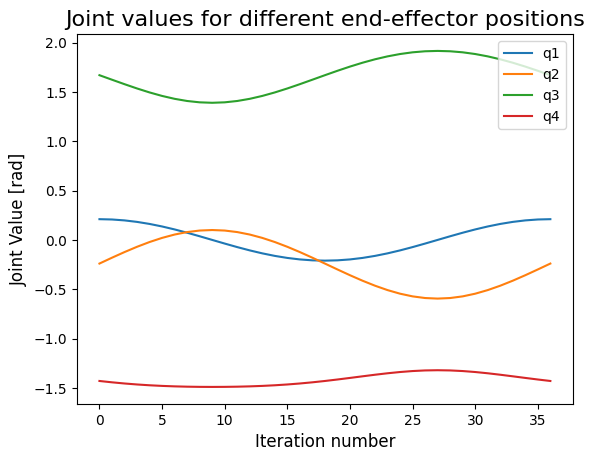

In [19]:
# P3
n = 36
psi_range = np.linspace(0, math.pi * 2, n+1)
pc = np.array([0.150, 0.0, 0.120])# -> Given
R = 0.032
# Preallocation
Q = np.zeros((len(psi_range), 4))
P = np.zeros((len(psi_range), 3))
P_FK = np.zeros((len(psi_range), 3))

for i in range(n+1):
    psi = psi_range[i]
    pp4 = pc + R * np.array([0, sym.cos(psi), sym.sin(psi)])

    # Get the joint values for every point:
    q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))
    
    TT4_FK = T04_FK(q[0], q[1], q[2], q[3])
    p_FK = np.array([TT4_FK[0][3], TT4_FK[1][3], TT4_FK[2][3]])

    # Save the values
    Q[i] = q
    P[i] = pp4
    P_FK[i][0] = TT4_FK[0][3]
    P_FK[i][1] = TT4_FK[1][3]
    P_FK[i][2] = TT4_FK[2][3]

#print(Q)
Q = np.transpose(Q)
P = np.transpose(P)
P_FK = np.transpose(P_FK)

# Checking
print(P - P_FK)

# Plotting
plt.plot(Q[0], label = 'q1')
plt.plot(Q[1], label = 'q2')
plt.plot(Q[2], label = 'q3')
plt.plot(Q[3], label = 'q4')
plt.legend()
plt.xlabel('Iteration number', fontsize = 12)
plt.ylabel('Joint Value [rad]', fontsize = 12)
plt.title('Joint values for different end-effector positions', fontsize = 16)
plt.show()

Text(0.5, 0, 'z')

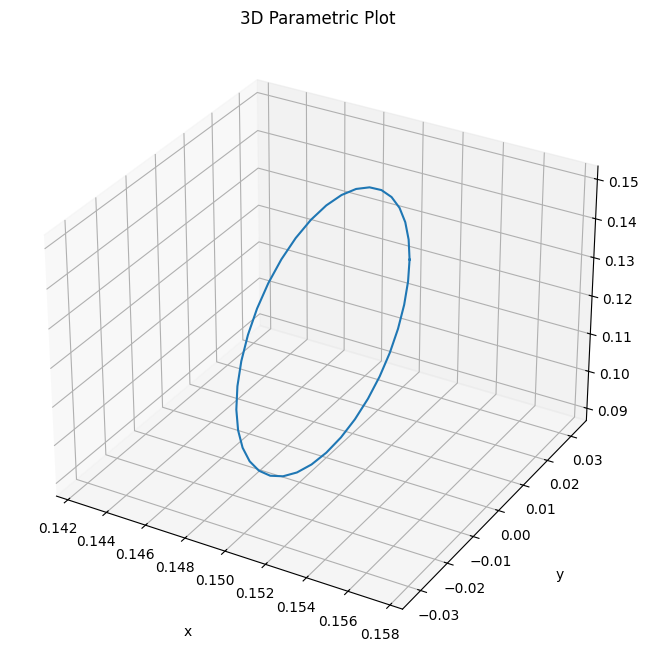

In [20]:
# FK of my Ik should give the same trajectory:


# 3D plot of the points:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
# # t = np.arange(0, 10*np.pi, np.pi/50)
# # x = np.sin(t)
# y = np.cos(t)

ax.plot3D(P[0], P[1], P[2])
ax.set_title('3D Parametric Plot')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

In [21]:
# Problem 4: Determine the Jacobian of the manipulator for the robot end-effector {frame 4: This is the stylus actually} and the Jacobian for the robot camera {frame 5} (as a function of the joint configuration q). Report the numerical results for the two Jacobians at φ = 0, φ = π/2, φ = π, and φ = 3π/2 along the path studies in Problem 3.

# # Get values
o00 = np.array([0, 0, 0])
z00 = np.array([0, 0, 1]) # By default
o01 = np.array([T01[0][3], T01[1][3], T01[2][3]])
z01 = np.array([T01[0][2], T01[1][2], T01[2][2]])
o02 = np.array([T02[0][3], T02[1][3], T02[2][3]])
z02 = np.array([T02[0][2], T02[1][2], T02[2][2]])
o03 = np.array([T03[0][3], T03[1][3], T03[2][3]])
z03 = np.array([T03[0][2], T03[1][2], T03[2][2]])
o04 = np.array([T04[0][3], T04[1][3], T04[2][3]])
z04 = np.array([T04[0][2], T04[1][2], T04[2][2]])
o05 = np.array([T05[0][3], T05[1][3], T05[2][3]])
z05 = np.array([T05[0][2], T05[1][2], T05[2][2]])
#o_n = np.array([T03[0][3], T03[1][3], T03[2][3]]) # T03 is only used for the end-effector position
# Be careful in here that the z0 is always [0,0,1]' and then z0i is given by
# the T0i. NOT by T0{i+1} !!! o_i is gien by T0{i} !!!


# Get Ji
J1 = get_Ji(z00, o00, o04, joints_type[0])
J2 = get_Ji(z01, o01, o04, joints_type[1])
J3 = get_Ji(z02, o02, o04, joints_type[2])
J4 = get_Ji(z03, o03, o04, joints_type[3])

J = np.transpose(np.concatenate([[J1], [J2], [J3], [J4]]))

# Printing
print('J')
print(J)

J
[[-(0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4))*sin(th1)
  (-0.093*sin(th2) - 0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*cos(th1)
  (-0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*cos(th1)
  -0.05*sin(th2 + th3 + th4)*cos(th1)]
 [(0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4))*cos(th1)
  (-0.093*sin(th2) - 0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*sin(th1)
  (-0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*sin(th1)
  -0.05*sin(th1)*sin(th2 + th3 + th4)]
 [0 0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4)
  0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4)
  0.05*cos(th2 + th3 + th4)]
 [0 1.0*sin(th1) 1.0*sin(th1) 1.0*sin(th1)]
 [0 -1.0*cos(th1) -1.0*cos(th1) -1.0*cos(th1)]
 [1 0 0 0]]


In [ ]:
#Problem 4: Determine the Jacobian of the manipulator for the robot end-effector and the Jacobian for the robot camera (as a function of the joint configuration q). Report the numerical results for the two Jacobians at psi = 0, psi = π/2, psi = π, and psi = 3π/2 along the path studies in Problem 3.
# # Jacobians, using numpy (not Sympy):
# TODO: J5 !! It is the same procedure BUT I don't know if the last part covers the DH convention, so MAYBE it will not work. I have the Sympy already done.

def get_J4(th11, th22, th33, th44):
  J4 = np.array([[-(0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44))*math.sin(th11),
    (-0.093*math.sin(th22) - 0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.cos(th11), (-0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.cos(th11), -0.05*math.sin(th22 + th33 + th44)*math.cos(th11)],
  [(0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44))*math.cos(th11),
    (-0.093*math.sin(th22) - 0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.sin(th11),
    (-0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.sin(th11),
    -0.05*math.sin(th11)*math.sin(th22 + th33 + th44)],
  [0, 0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44),
    0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44),
    0.05*math.cos(th22 + th33 + th44)],
  [0, 1.0*math.sin(th11), 1.0*math.sin(th11), 1.0*math.sin(th11)],
  [0, -1.0*math.cos(th11), -1.0*math.cos(th11), -1.0*math.cos(th11)],
  [1, 0, 0, 0]])
  return J4

psi_index = np.array([np.where(psi_range == 0)[0][0], np.where(psi_range == math.pi/2)[0][0], np.where(psi_range == math.pi)[0][0], np.where(psi_range == 3*math.pi/2)[0][0]])
print("psi_index: ", psi_index) # This is the n iteration with the 4 desired psi values. Now I want their Jacobians (J4):

# P4
# Preallocation
J_tot_4 = []

for i in psi_index:
    psi = psi_range[i]
    pp4 = pc + R * np.array([0, sym.cos(psi), sym.sin(psi)])

    # Get the joint values for every point:
    q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))
    
    J_i = get_J4(q[0], q[1], q[2], q[3])

    # Save the values
    J_tot_4.append(J_i)


# post-processing
J_tot_4 = np.transpose(J_tot_4)

# Printing
print(J_tot_4)


psi_index:  [ 0  9 18 27]
[[[-3.20000000e-02 -1.95943488e-18  3.20000000e-02  5.87830464e-18]
  [ 1.50000000e-01  1.50000000e-01  1.50000000e-01  1.50000000e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]

 [[-6.84594985e-02 -1.02000000e-01 -6.84594985e-02 -3.80000000e-02]
  [-1.46046930e-02 -1.33241572e-18  1.46046930e-02  1.48917051e-18]
  [ 1.53375357e-01  1.50000000e-01  1.53375357e-01  1.50000000e-01]
  [ 2.08638472e-01  1.30628992e-17 -2.08638472e-01 -3.91886976e-17]
  [-9.77992836e-01 -1.00000000e+00 -9.77992836e-01 -1.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[-9.00555097e-02 -9.26998169e-02 -9.00555097e-02 -9.01173125e-02]
  [-1.92118421e-02 -1.21092836e-18  1.92118421e-02  3.53158011e-18]
  [ 6.30349643e-02

In [122]:
# Get the inverse velocities !! 
# For 1 J4:
J44 = J_tot_4[0]
print('J44: \n', J44)

J44_inv = np.linalg.pinv(J44)

print('J44_pinv: \n', J44_inv)
print(np.linalg.matrix_rank(J44))

J44: 
 [[-3.20000000e-02 -1.95943488e-18  3.20000000e-02  5.87830464e-18]
 [ 1.50000000e-01  1.50000000e-01  1.50000000e-01  1.50000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
J44_pinv: 
 [[-1.56250000e+01  3.66748166e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.44498778e-01]
 [ 1.47196168e-14  3.66748166e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.44498778e-01]
 [ 1.56250000e+01  3.66748166e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.44498778e-01]
 [ 1.34929821e-14  3.66748166e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.44498778e-01]]
2


In [103]:
#Problem 4: Determine the Jacobian of the manipulator for the robot end-effector and the Jacobian for the robot
#  camera (as a function of the joint configuration q). Report the numerical results for the two Jacobians 
# at psi = 0, psi = π/2, psi = π, and psi = 3π/2 along the path studies in Problem 3.
Q = []
a = np.array([[1, 2, 3], [2, 3, 4]])
print(Q)
print(a)
print('---')
Q.append(a)
print(Q)


[]
[[1 2 3]
 [2 3 4]]
---
[array([[1, 2, 3],
       [2, 3, 4]])]


In [ ]:
# Problem 5: Compute the joint velocities q˙ at psi = π/2, along the path from Problem 3, so that the stylus tip 
# velocity is v04 = [0,−3, 0]mm/s and dx4 = [?, ?, 0].
# Hint: the last quantity dx4, you have not seen it as such in the course before, so you need to think about how to 
# interpret it in terms of angular velocities.


In [ ]:
# Otra forma de sacar los angulos
# TODO: Lo que tengo que hacer es ver como pasar de la formula del libro, que tiene en cuenta
# algunos angulos en particular (y creo que siempre son menores a 90) a mis variables de angulos,
# segun las coordenadas que me dan

def get_th1(x, y):
    th1 = (math.atan2(y, x))#* 180 / math.pi #+ math.pi
    return th1

def get_x3(x4, y4, z4, th1, l4):
    x3 = x4 - math.cos(th1) *l4
    y3 = y4 - math.sin(th1) *l4
    z3 = z4
    out_vec = np.array([x3, y3, z3])
    return out_vec

def get_th3(xc, yc, zc, offset, l1, l2, l3, type):
    D = (xc**2 + yc**2 - offset**2 + (zc - l1)**2 - l2**2- l3**2) / (2*l2*l3)
    if type == "elbow-up":
        th3 = math.atan2(math.sqrt(1 - D ** 2), D)
    else:
        th3 = math.atan2(-math.sqrt(1 - D ** 2), D)
        print('pase por elbow-down')
    th3 = math.pi/2 - math.acos(D)
    #th3 = -(math.pi/2 - th3)
    return th3

def get_th2(xc, yc, zc, th3, offset, l1):
    part1 = math.atan2(zc - l1, math.sqrt(xc**2 + yc**2 - offset**2))
    part2 = math.atan2(l3 * math.sin(th3), l2 + l3 * math.cos(th3))
    print('part1 ', math.degrees(part1), 'part2 ', math.degrees(part2))
    th2 = (part1 - part2)
    #th3 = (math.pi/2 - th2)
    return th2

def get_th4(th2, th3):
    th4 = (math.pi/2 - th2 - th3)
    return th4

# Testing:
#pp4 = np.array([150.0, 0.0, 120.0])# -> Given
'''
thetas reales:
rad: 0 -0.2617993877991494 -0.5235987755982988 -0.7853981633974483
deg: 0 -15                 -30                 -45
esperaria tener:
     0  75                 60                   45?
'''
pp4 = np.array([139.831, 0.0, 205.592])# -> Given
#R = 32
#psi = 0.5
#ppp4 = pp4 + R * np.array([0, sym.cos(psi), sym.sin(psi)])
#angle1 = get_th1(pp4[0], pp4[1])

# Para sacar (x3, y3, z3)
l1 = 50
l2 = 93
l3 = 93
l4 = 50
offset = 0
type = "elbow-up"

# Angulo 1
angle1 = get_th1(pp4[0], pp4[1])
# x3 -> Esta bien
pp3 = get_x3(pp4[0],pp4[1],pp4[2], angle1, l4)
print('x3: ', pp3)
print('x4: ', pp4)
print('---')
# Para sacar th2 y th3:
angle3 = get_th3(pp3[0],pp3[1],pp3[2], offset, l1, l2, l3, type)
angle2 = get_th2(pp3[0],pp3[1],pp3[2], angle3, offset, l1)
angle4 = get_th4(angle2, angle3)

print('---')
print('     radians /  degree')
print('th1:   ', "%.2f" % angle1," / ", "%.2f" % (angle1 * 180 / math.pi))
print('th2:   ', "%.2f" % angle2," / ", "%.2f" % (angle2 * 180 / math.pi))
print('th3:   ', "%.2f" % angle3," / ", "%.2f" % (angle3 * 180 / math.pi))
print('th4:   ', "%.2f" % angle4," / ", "%.2f" % (angle4 * 180 / math.pi))


######
######
ang2 = math.radians(45)
ang3 = math.radians(-30)
xx3 = l2 * math.cos(ang2) + l3 * math.cos(ang2 + ang3)
yy3 = 0
zz3 = l2 * math.sin(ang2) + l3 * math.sin(ang2 + ang3)
d1 = 0 
print('---')
print('th2: ', math.degrees(ang2), '\nth3: ', math.degrees(ang3), '\n xx3: ', xx3, '\n yy3: ' , zz3)
print('---')
print('From IK:')

# Get IK:
D = (xx3 ** 2 + yy3 ** 2 + zz3 ** 2 - l2 ** 2 - l3 ** 2) / (2 * l2 * l3)
ang3_IKK = math.atan2(-math.sqrt(1 - D ** 2), D) # Add a (-) to the first part and we get the elbow down.
ang2_IK_01 = math.atan2(zz3, xx3)
ang2_IK_02 = math.atan2(l3 * math.sin(ang3_IKK), l2 + l3 * math.cos(ang3_IKK))
#print(math.degrees(ang2_IK_01), math.degrees(ang2_IK_02))
ang2_IK = ang2_IK_01 - ang2_IK_02
print('th2_IK: ', math.degrees(ang2_IK))
print('th3_IK: ', math.degrees(ang3_IKK))
# This works good !! The same as in the .m files.
# FK and IK checked with this. Now to add it to the real final thing.

x3:  [ 89.831   0.    205.592]
x4:  [139.831   0.    205.592]
---
part1  60.00002294630886 part2  29.999905899573967
---
     radians /  degree
th1:    0.00  /  0.00
th2:    0.52  /  30.00
th3:    1.05  /  60.00
th4:    0.00  /  0.00
---
th2:  45.0 
th3:  -29.999999999999996 
 xx3:  155.59203249523227 
 yy3:  89.83110184488336
---
From IK:
th2_IK:  44.999999999999986
th3_IK:  -29.99999999999997


#######################################################
#######################################################

In [ ]:
# This is actually a 2-link example. So I will not pay attention to the 3rd link.
# I need T0i. In fact I only need the 3rd and 4th columns. But, for practice I will make all T/
# I need Ai:
# 2 ways of accomplishing it: (1) DH-param, (2) by inspection.
# (1)
th1, th2, a1, a2 = sym.symbols('th1 th2 a1 a2')
ac = a2/2
o00 = np.array([0, 0, 0])
joints_type = [1, 1] # 1 for revolute, 0 for prismatic

# def get_A(theta, d, a, alpha):
DH_1 = np.array([th1, 0, a1, 0])
DH_2 = np.array([th2, 0, ac, 0])

A1 = get_A(DH_1[0], DH_1[1], DH_1[2], DH_1[3])
A2 = get_A(DH_2[0], DH_2[1], DH_2[2], DH_2[3])

T01 = A1
T02 = A1 @ A2

z00 = np.array([T01[0][2], T01[1][2], T01[2][2]])
o_c = np.array([T02[0][3], T02[1][3], T02[2][3]])
z01 = np.array([T02[0][2], T02[1][2], T02[2][2]])
o01 = np.array([T01[0][3], T01[1][3], T01[2][3]])

J1 = get_Ji(z00, o00, o_c, joints_type[0])
J2 = get_Ji(z01, o01, o_c, joints_type[0])

J = np.transpose(np.concatenate([[J1], [J2]]))
print('J')
print(J)
# The math is alright. I have a problem with the definition of the np.arrays and the functions
# And how to concatenate them to get a new matrix that is only 1 np.array

J
[[-a1*sin(th1) - a2*sin(th1 + th2)/2 -a2*sin(th1 + th2)/2]
 [a1*cos(th1) + a2*cos(th1 + th2)/2 a2*cos(th1 + th2)/2]
 [0 0]
 [0 0]
 [0 0]
 [1 1]]


In [ ]:
# P3 Similar to before. The process is:
# Find DH-parameters
# Find Ai
# Find T0i
# Find Ji
# Make J

# Info
joints_type = [1, 0, 0] # 1 for revolute, 0 for prismatic
th1, d1, d2, d3 = sym.symbols('th1, d1, d2, d3')
# It is given in a weird way actually. To confuse you probably. a_i = d_i ?

# DH-param
'''
th_i    --> Angle from x_{i-1} to x_{i} measured in a plane normal to z_{i-1}
d_i     --> d is the perpendicular distance from o_{i-1} to the intersection of 
            x_{i} with z_{i-1}, measured along the z_{i-1} axis.
a_i     --> Distance between the axes z_{i-1} and z_{i}, and is measured along the axis x{i}
alpha_i --> Angle between the axes z_{i-1} and z_{i}, measured in a plane normal to x_{i}
'''
# def get_A(theta, d, a, alpha):
DH_1 = np.array([th1, d1, 0, 0])
DH_2 = np.array([0, d2, 0, -sym.pi/2]) # Itis pi/2. Not pi !!! 
DH_3 = np.array([0, d3, 0, 0])

A1 = get_A(DH_1[0], DH_1[1], DH_1[2], DH_1[3])
A2 = get_A(DH_2[0], DH_2[1], DH_2[2], DH_2[3])
A3 = get_A(DH_3[0], DH_3[1], DH_3[2], DH_3[3])
#A4 = get_A(DH_4[0], DH_4[1], DH_4[2], DH_4[3])

T01 = A1
T02 = A1 @ A2
T03 = A1 @ A2 @ A3

# Get values
o00 = np.array([0, 0, 0])
z00 = np.array([0, 0, 1]) # By default #np.array([T01[0][2], T01[1][2], T01[2][2]])
o01 = np.array([T01[0][3], T01[1][3], T01[2][3]])
z01 = np.array([T01[0][2], T01[1][2], T01[2][2]])
o02 = np.array([T02[0][3], T02[1][3], T02[2][3]])
z02 = np.array([T02[0][2], T02[1][2], T02[2][2]])
o_n = np.array([T03[0][3], T03[1][3], T03[2][3]]) # T03 is only used for the end-effector position
# Be careful in here that the z0 is always [0,0,1]' and then z0i is given by
# the T0i. NOT by T0{i+1} !!! o_i is gien by T0{i} !!!

# Get Ji
J1 = get_Ji(z00, o00, o_n, joints_type[0])
J2 = get_Ji(z01, o01, o_n, joints_type[1])
J3 = get_Ji(z02, o02, o_n, joints_type[2])

J = np.transpose(np.concatenate([[J1], [J2], [J3]]))

# Printing
print('J')
print(J)

J
[[-d3*cos(th1) 0 -sin(th1)]
 [-d3*sin(th1) 0 cos(th1)]
 [0 1 0]
 [0 0 0]
 [0 0 0]
 [1 0 0]]


In [ ]:
# P4:
# The planar manipulator with a mobile platform moving in Z direction shown below can
# be interpreted as a PRR manipulator. The robot operates only in the XZ plane in 
# the working space.
# Define the coordinate frames 1 and 2 according to the Denavit-Hartenberg convention. 
# Define frame 3 according to the usual convention for the end-effector, assuming 
# that the grip opens and closes in the out of plane direction. Determine the 
# transformation matrix T03 , and find the Jacobian matrix for this mobile robot. 
# Note: the end-effector frame does not follow the Denavit-Hartenberg convention, 
# hence there is some ambiguity in how you define angle th3.


In [ ]:
# y0 comes my way (out of the page)
# # z comes my way in both joints.
# x follows the links
# y is determined by the right-hand-rule -> up-left direction

# Same as before
# Info
joints_type = [0, 1, 1] # 1 for revolute, 0 for prismatic
th2, th3, d1, a2, a3 = sym.symbols('th2, th3, d1, a2, a3')
# It is given in a weird way actually. To confuse you probably. a_i = d_i ?

# DH-param
'''
th_i    --> Angle from x_{i-1} to x_{i} measured in a plane normal to z_{i-1}
d_i     --> d is the perpendicular distance from o_{i-1} to the intersection of 
            x_{i} with z_{i-1}, measured along the z_{i-1} axis.
a_i     --> Distance between the axes z_{i-1} and z_{i}, and is measured along the axis x{i}
alpha_i --> Angle between the axes z_{i-1} and z_{i}, measured in a plane normal to x_{i}
'''
# def get_A(theta, d, a, alpha):
DH_1 = np.array([0, d1, 0, -sym.pi/2])
DH_2 = np.array([th2, 0, a2, 0]) # Itis pi/2. Not pi !!! 
'''DH_3 = np.array([th3, 0, a3, 0])''' # -> Doesn't follow DH convention

A1 = get_A(DH_1[0], DH_1[1], DH_1[2], DH_1[3])
A2 = get_A(DH_2[0], DH_2[1], DH_2[2], DH_2[3])
# In this caseA3 does not follow DH conventions:
A3 = np.array([[sym.cos(th3), 0, sym.sin(th3), a3*sym.sin(th3)],
               [sym.sin(th3), 0, -sym.cos(th3), -a3*sym.cos(th3)],
               [0, 1, 0, 0],
               [0, 0, 0, 1]])
'''A4 = get_A(DH_4[0], DH_4[1], DH_4[2], DH_4[3])'''

T01 = sym.simplify(A1)
T02 = sym.simplify(A1 @ A2)
T03 = sym.simplify(A1 @ A2 @ A3)

# Get values
o00 = np.array([0, 0, 0])
z00 = np.array([0, 0, 1]) # By default #np.array([T01[0][2], T01[1][2], T01[2][2]])
o01 = np.array([T01[0][3], T01[1][3], T01[2][3]])
z01 = np.array([T01[0][2], T01[1][2], T01[2][2]])
o02 = np.array([T02[0][3], T02[1][3], T02[2][3]])
z02 = np.array([T02[0][2], T02[1][2], T02[2][2]])
o_n = np.array([T03[0][3], T03[1][3], T03[2][3]]) # T03 is only used for the end-effector position
# Be careful in here that the z0 is always [0,0,1]' and then z0i is given by
# the T0i. NOT by T0{i+1} !!! o_i is gien by T0{i} !!!


# Get Ji
J1 = get_Ji(z00, o00, o_n, joints_type[0])
J2 = get_Ji(z01, o01, o_n, joints_type[1])
J3 = get_Ji(z02, o02, o_n, joints_type[2])

J = np.transpose(np.concatenate([[J1], [J2], [J3]]))

# Printing
print('J')
print(J)

[0 1 0]
J
[[0 -a2*sin(th2) + a3*cos(th2 + th3) a3*cos(th2 + th3)]
 [0 0 0]
 [1 -a2*cos(th2) - a3*sin(th2 + th3) -a3*sin(th2 + th3)]
 [0 0 0]
 [0 1 1]
 [0 0 0]]
